In [1]:
#%matplotlib inline
%matplotlib notebook

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from six.moves import cPickle as pickle
from sklearn.manifold import TSNE
from collections import Counter
from glob import glob

plt.style.use('ggplot')

### Helper Functions

In [2]:
def gc(sequence):
    sequence = sequence.upper()
    return (sequence.count('G') + sequence.count('C')) / float(len(sequence))


def seq_entropy(sequence):
    bases = {'A', 'C', 'G', 'T'}
    c = Counter(sequence.upper())
    tot = float(sum([c[b] for b in bases]))
    c = {b: c[b]/tot for b in bases}
    
    return sum([(-c[b]) * np.log2(c[b]) for b in bases if c[b] > 0])


def patten2number(sequence):
    """ Converts DNA sequence into an int. """
    BASE_TO_NUMBER = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    if len(sequence) == 0:
        return 0
    last_base = sequence[-1]
    prefix = sequence[:-1]
    return 4 * patten2number(prefix) + BASE_TO_NUMBER[last_base]
    

def number2patten(number, kmer_size):
    """ Converts an int into a string with k nucleotides. """
    NUMBER_TO_BASE = ('A', 'C', 'G', 'T')
    if kmer_size == 1:
        return NUMBER_TO_BASE[number]
    prefix_index = number // 4
    base = NUMBER_TO_BASE[number % 4]
    return number2patten(prefix_index, kmer_size - 1) + base

### Load Embeddings

In [3]:
KMER_SIZE = 6

kmer_sizes = np.array([3, 4, 5, 6, 7, 8])
offset = np.concatenate(([0], (4**kmer_sizes))).cumsum()
index = np.where(kmer_sizes == KMER_SIZE)[0][0]

assert KMER_SIZE in kmer_sizes

pickle_file = '../max8_min3_mers_30padding_300embedding/max8_min3_mers_30padding_300embedding_epoch1_batch0.npy'
pre_normalized_embeddings = np.load(pickle_file)

glob_str = '../max8_min3_mers_30padding_300embedding/max8_min3_mers_30padding_300embedding_epoch1_batch*.npy'
emb_files = {int(f.rstrip('.npy').split('batch')[1]): f for f in glob(glob_str)}
pickle_file = emb_files[sorted(emb_files)[-1]]
print(pickle_file)
        
post_normalized_embeddings = np.load(pickle_file)

print(pre_normalized_embeddings.shape)
print(post_normalized_embeddings.shape)

# Get k-mers
pre_normalized_embeddings = pre_normalized_embeddings[offset[index]:offset[index+1]]
post_normalized_embeddings = post_normalized_embeddings[offset[index]:offset[index+1]]

print(' Pre Only {}-mers:'.format(KMER_SIZE), pre_normalized_embeddings.shape)
print('Post Only {}-mers:'.format(KMER_SIZE), post_normalized_embeddings.shape)

../max8_min3_mers_30padding_300embedding/max8_min3_mers_30padding_300embedding_epoch1_batch177000000.npy
(87360, 300)
(87360, 300)
 Pre Only 6-mers: (4096, 300)
Post Only 6-mers: (4096, 300)


### Convert into 2D Space (t-distributed stochastic neighbor embedding (t-SNE))

In [4]:
NUM_POINTS = 4096

random_kmers = np.random.choice(4**KMER_SIZE, NUM_POINTS, replace=False)
random_kmers.sort()
print(len(random_kmers), random_kmers[:10])

4096 [ 2  4  5 13 16 25 32 33 34 37]


In [4]:
# Subset
#labels = random_kmers  # Needs to be sorted
# All
labels = range(4**KMER_SIZE)

labels_entropy = [seq_entropy(number2patten(s, KMER_SIZE)) for s in labels]
labels_gc = [gc(number2patten(s, KMER_SIZE)) for s in labels]

# Frequence in hg38
labels_frequence = {}
for kmer in open('../reference_vocabulary/all_{}-mers.tsv'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence[seq] = freq
    
labels_frequence = [np.log10(labels_frequence[k]) for k in sorted(labels_frequence.keys())]

# Frequence in hg38 LINE
labels_frequence_line = {}
for kmer in open('../reference_vocabulary/rmsk_LINE_{}-mers.tsv'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence_line[seq] = freq

labels_frequence_line = [np.log10(labels_frequence_line[k]) for k in sorted(labels_frequence_line.keys())]
    
# Frequence in hg38 SINE
labels_frequence_sine = {}
for kmer in open('../reference_vocabulary/rmsk_SINE_{}-mers.tsv'.format(KMER_SIZE)):
    seq, freq = kmer.split()
    seq = patten2number(seq)
    freq = int(freq)
    if seq in labels:
        labels_frequence_sine[seq] = freq

labels_frequence_sine = [np.log10(labels_frequence_sine[k]) for k in sorted(labels_frequence_sine.keys())]

    
print(len(labels_entropy), labels_entropy[:10])
print(len(labels_gc), labels_gc[:10])
print(len(labels_frequence), labels_frequence[:10])
print(len(labels_frequence_line), labels_frequence_line[:10])
print(len(labels_frequence_sine), labels_frequence_sine[:10])

4096 [0.0, 0.65002242164835411, 0.65002242164835411, 0.65002242164835411, 0.65002242164835411, 0.91829583405448956, 1.2516291673878228, 1.2516291673878228, 0.65002242164835411, 1.2516291673878228]
4096 [0.0, 0.16666666666666666, 0.16666666666666666, 0.0, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333]
4096 [6.9917401886540276, 6.3445005390397089, 6.4504366460770504, 6.6684929859713158, 6.4452264051557995, 6.1113720818806065, 5.3862206425498735, 6.2805296574584819, 6.4590597027815271, 6.1135315796193268]
4096 [6.2307926443650885, 5.7889746743174317, 5.8702241802175124, 6.0244602168042105, 5.8669273777272499, 5.6004904412031973, 4.7029816716488089, 5.7152761270448833, 5.9280812845729569, 5.5343206152976281]
4096 [6.611537232959499, 5.2443563011811785, 5.3960685158003043, 5.95198265166146, 5.3672981355125673, 4.9857811303090216, 4.1392492175716074, 5.0300286521505395, 5.4051550440275999, 4.6306719063941921]


In [5]:
tsne = TSNE(perplexity=15, n_components=2, init='pca', n_iter=5000, learning_rate=10)

## Subset
#pre_two_d_embeddings = tsne.fit_transform([pre_normalized_embeddings[s, :] for s in random_kmers])
#post_two_d_embeddings = tsne.fit_transform([post_normalized_embeddings[s, :] for s in random_kmers])

## All
pre_two_d_embeddings = tsne.fit_transform(pre_normalized_embeddings)
post_two_d_embeddings = tsne.fit_transform(post_normalized_embeddings)

### Looking at the Result

<IPython.core.display.Javascript object>


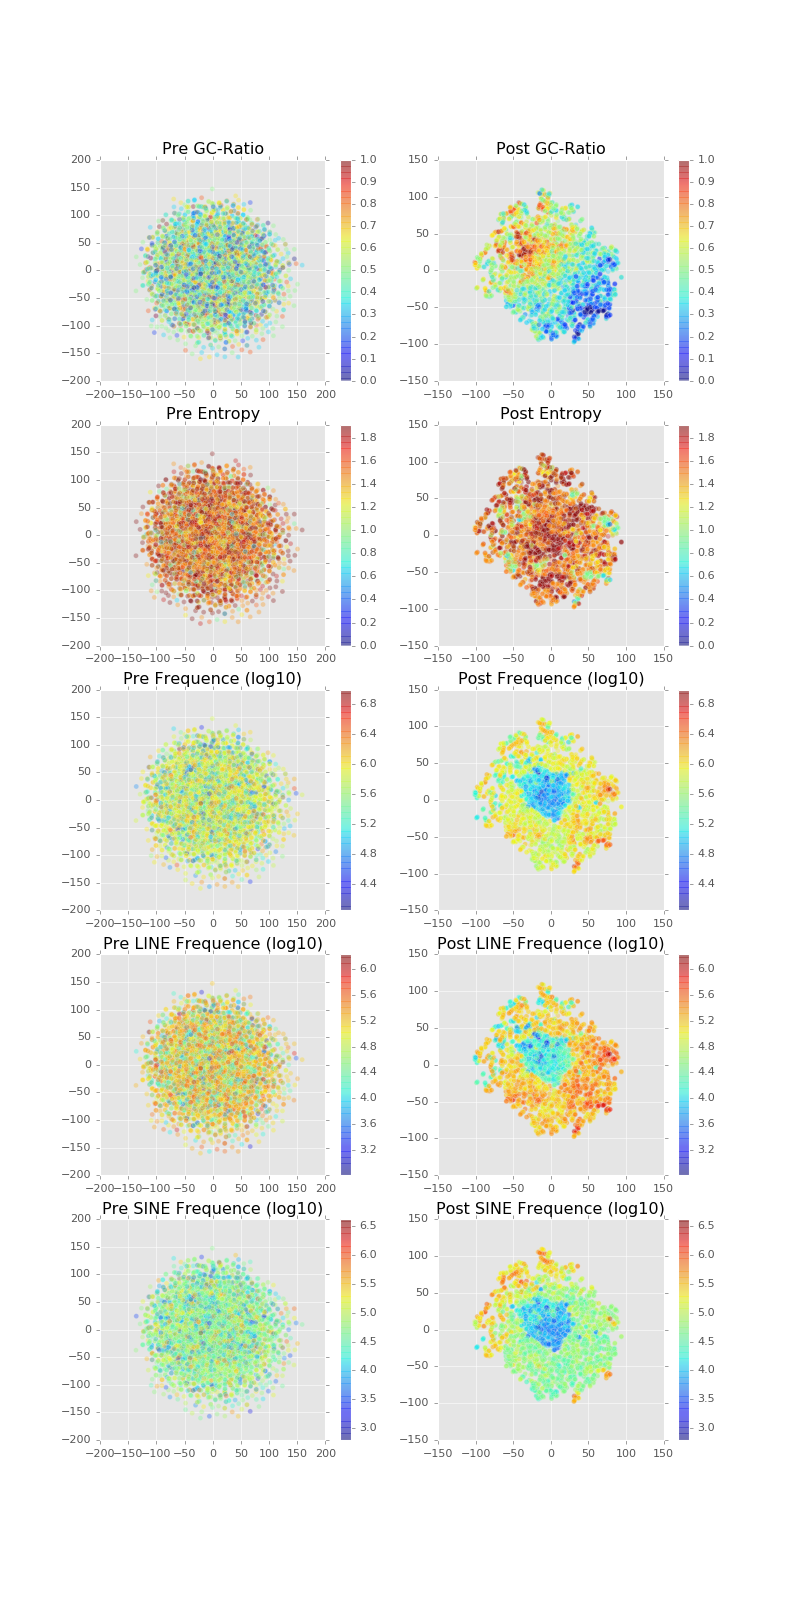

In [6]:
def plot(x, y, labels, title):
    norm = colors.Normalize(vmin=min(labels), vmax=max(labels))
    plt.scatter(x, y, c=labels, alpha=0.3, cmap=plt.get_cmap('jet'), norm=norm)
    plt.colorbar()
    plt.title(title)

pre_x = pre_two_d_embeddings[:, 0]
pre_y = pre_two_d_embeddings[:, 1]

post_x = post_two_d_embeddings[:, 0]
post_y = post_two_d_embeddings[:, 1]

plt.figure(figsize=(10, 20))  # in inches

plt.subplot(5,2,1)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_gc, 'Pre GC-Ratio')

plt.subplot(5,2,2)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_gc, 'Post GC-Ratio')

plt.subplot(5,2,3)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_entropy, 'Pre Entropy')

plt.subplot(5,2,4)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_entropy, 'Post Entropy')

plt.subplot(5,2,5)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence, 'Pre Frequence (log10)')

plt.subplot(5,2,6)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence, 'Post Frequence (log10)')

plt.subplot(5,2,7)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence_line, 'Pre LINE Frequence (log10)')

plt.subplot(5,2,8)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence_line, 'Post LINE Frequence (log10)')

plt.subplot(5,2,9)
plot(pre_two_d_embeddings[:, 0], pre_two_d_embeddings[:, 1], labels_frequence_sine, 'Pre SINE Frequence (log10)')

plt.subplot(5,2,10)
plot(post_two_d_embeddings[:, 0], post_two_d_embeddings[:, 1], labels_frequence_sine, 'Post SINE Frequence (log10)')


plt.show()

### 3D

In [ ]:
tsne_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=10000, learning_rate=10)

#post_3d_embeddings = tsne_3d.fit_transform([post_normalized_embeddings[s, :] for s in random_kmers])

# All
post_3d_embeddings = tsne_3d.fit_transform(post_normalized_embeddings)

In [ ]:
post_x = post_3d_embeddings[:, 0]
post_y = post_3d_embeddings[:, 1]
post_z = post_3d_embeddings[:, 2]

fig = plt.figure(figsize=(12,12))
ax = plt.axes(projection='3d')
plt.gca().patch.set_facecolor('white')

label_type = labels_frequence

norm = colors.Normalize(vmin=min(label_type), vmax=max(label_type))
ax.scatter(post_x, post_y, post_z, alpha=0.3, c=label_type, cmap=plt.get_cmap('jet'), norm=norm)

plt.show()